##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
#Import all necessary libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As we can see above, the same user has multiple reviews with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that :
<br> <br>
ProductId=B000HDOPZG was Loacker Quadratini <b>Vanilla</b> Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini <b>Lemon</b> Wafer Cookies, 8.82-Ounce Packages (Pack of 8), and so on<br>

Thus, we can see that they are the same product, but of different flavors. Hence, the rows having the same values of the parameters mentioned above were eliminated for reducing redundancy.<br>

The method used for the same is to first sort the data according to ProductId and then retain only the first product review details, while deleting the rest. For example, out of he above lines, just the review for ProductId=B000HDL1RQ is retained and others deleted. This method ensures that only one representative for each product from any given user remains.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(364173, 10)


69.25890143662969

<b>Observation:-</b> It was also seen that in the two rows given below, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from our calcualtions.

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing let's see the number of entries left
print(final.shape)

#How many positive and negative reviews each are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Having finished deduplication, our data still requires some preprocessing before we can go on further with analysis and visualization.
Hence in the Preprocessing phase we do the following in the given order:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'before', 'how', 'about', 'themselves', 'against', 'so', 'more', 'above', 'then', 'having', 'your', 'didn', 'once', 'other', 'only', 'yours', 'are', 'm', 'own', 'under', 'doing', 'because', 'such', 'out', 'into', 'o', 'being', 've', 'over', 'each', 'does', 'there', 'it', 'we', 'off', 'its', 'is', 'again', 'him', 'during', 'their', 'for', 'an', 'to', 'herself', 'up', 'through', 'these', 'when', 'have', 'this', 'me', 'what', 'll', 'been', 'all', 'isn', 'and', 'both', 'mightn', 'ours', 'now', 'between', 'yourself', 'couldn', 'haven', 'of', 'at', 'no', 'ain', 'not', 'theirs', 'were', 'hadn', 'weren', 'do', 'itself', 'the', 'too', 'd', 'his', 'from', 'who', 'can', 'had', 'or', 'needn', 'aren', 'wasn', 'i', 'mustn', 'she', 'they', 'in', 't', 'was', 'y', 'by', 'few', 'will', 'shouldn', 'whom', 'our', 'until', 'most', 'you', 'doesn', 'down', 'did', 'ma', 'while', 'below', 're', 'any', 'hasn', 'with', 'a', 'her', 'has', 'am', 'that', 'be', 'my', 'further', 'shan', 'if', 'as', 'very', 'myself',

## Code for implementing all preprocessing steps mentioned earlier

In [14]:
# This code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:15<00:00, 735.08it/s]


In [12]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please execute the above cell")

# Bag of Words (BoW)
We are generating a Bag of Words model only from the first 3000 reviews of the preprocessed dataset so that the t-SNE algorithm does not take too much time to run.

In [35]:
#Generate a BoW sparse matrix for the first 3000 reviews
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final[:3000]['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3000, 8112)
the number of unique words  8112


## t-SNE Plot for BoW using Scikit-Learn

Below, we will be running the t-SNE algorithm on the sparse matrix generated from the first 3000 reviews, which contains 8112 unique  words, but only after converting it into a dense matrix using the toarray() method.<br>
The resultant matrix, which has 2 dimensions for every row, is then concatenated with the Scores(1 or 0) predicted earlier, and transposed to generate a dataframe, from which a scatter plot is drawn, with each point indicating the predicted Score.<br>
By default, the perplexity is 30 and number of iterations is 1000.

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.394937
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.003731
[t-SNE] Error after 300 iterations: 1.003731


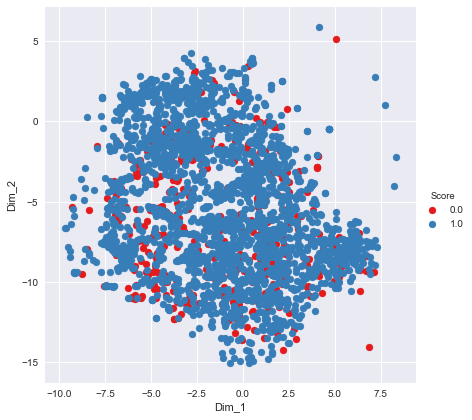

In [17]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, verbose=1)
data_tsne = model.fit_transform(final_counts.toarray())

# creating a new data frame which helps us in ploting the result data
tsne_data_df = pd.DataFrame(data=np.vstack((data_tsne.T, final[:3000]['Score'])).T, columns=['Dim_1', "Dim_2", "Score"])

# Ploting the result of tsne
sns.set()
sns.FacetGrid(tsne_data_df, hue="Score", size=6, palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF
We are again generating a TF-IDF representation of the only the first 3000 reviews in the dataset, and running the t-SNE algorithm on it.

In [18]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final[:3000]['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3000, 102001)
the number of unique words including both unigrams and bigrams  102001


## t-SNE Plot for TF-IDF using Scikit-Learn

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.192902
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.468597
[t-SNE] Error after 200 iterations: 1.468597


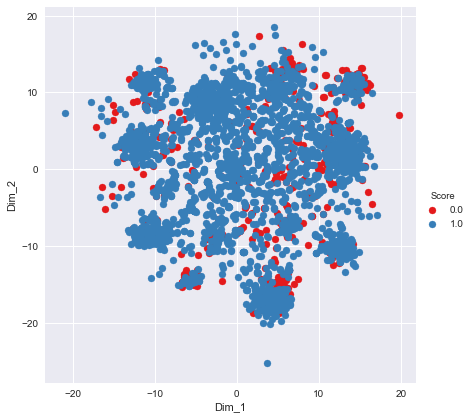

In [19]:
model = TSNE(n_components=2, random_state=0, verbose=1)
#final_counts.toarray()
data_tsne = model.fit_transform(final_tf_idf.toarray())

tsne_data_df = pd.DataFrame(data=np.vstack((data_tsne.T, final[:3000]['Score'])).T, columns=['Dim_1', "Dim_2", "Score"])
# Ploting the result of tsne
sns.set()
sns.FacetGrid(tsne_data_df, hue="Score", size=6, palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Word2Vec

In [20]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google, a 3.3G file,which will occupy ~9Gb once 
# loaded into memory, so please do this step only if you have >12G of RAM.
# Alternativelly, we can use the provided pickle file wich contains a dict , 
# and it contains all our corpus words as keys and  model[word] as values.
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

is_your_ram_gt_16g=True
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [21]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [22]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [23]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [24]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
w2v_model.wv.most_similar('tasti')

number of words that occured minimum 5 times  21938
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


[('delici', 0.8017680048942566),
 ('yummi', 0.7849210500717163),
 ('tastey', 0.782333493232727),
 ('good', 0.6744653582572937),
 ('satisfi', 0.6687943935394287),
 ('nice', 0.667802095413208),
 ('delish', 0.6524054408073425),
 ('hearti', 0.6481248140335083),
 ('crunchi', 0.6239860653877258),
 ('nutriti', 0.623684287071228)]

# Avg W2V
Below, we are generating an Average Word2Vec representation on the first 3000 review of the dataset, to generate a 50-dimensional vector for each review sentence.

In [25]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(list_of_sent))
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [11:37<00:00, 522.11it/s]


364171
364171
50


## t-SNE Plot for Average Word2Vec using Scikit-Learn

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.978990
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.323305
[t-SNE] Error after 225 iterations: 1.323305


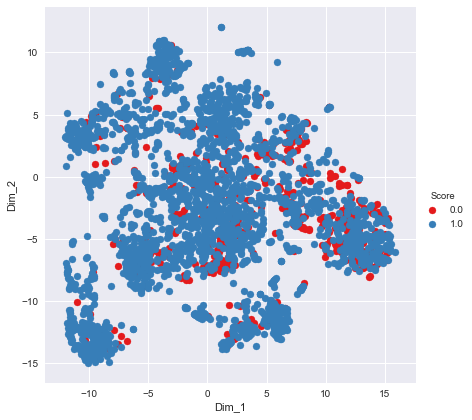

In [32]:
model = TSNE(n_components=2, random_state=0, verbose=1)
#final_counts.toarray()
data_tsne = model.fit_transform(np.array(sent_vectors[:3000]))

tsne_data_df = pd.DataFrame(data=np.vstack((data_tsne.T, final[:3000]['Score'])).T, columns=['Dim_1', "Dim_2", "Score"])
# Ploting the result of tsne
sns.set()
sns.FacetGrid(tsne_data_df, hue="Score", size=6, palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF Weighted W2V
Below, we are generating a TF-IDF Weighted Word2Vec representation on the first 3000 review of the dataset, using the Word to Vec model generated earlier, and TF-IDF values of each word to generate a 50-dimensional vector for each review sentence.

In [33]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [12:29<00:00, 485.81it/s]


## t-SNE Plot for TF-IDF Weighted Word2Vec using Scikit-Learn

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.241448
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.320614
[t-SNE] Error after 375 iterations: 1.320614


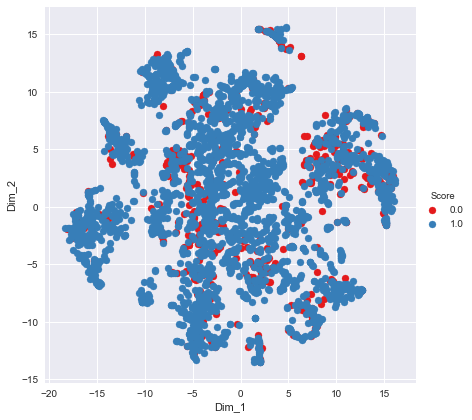

In [34]:
model_tsne = TSNE(n_components=2, random_state=0, verbose=1)
#final_counts.toarray()
data_tsne = model_tsne.fit_transform(np.array(tfidf_sent_vectors[:3000]))

tsne_data_df = pd.DataFrame(data=np.vstack((data_tsne.T, final[:3000]['Score'])).T, columns=['Dim_1', "Dim_2", "Score"])
# Ploting the result of tsne
sns.set()
sns.FacetGrid(tsne_data_df, hue="Score", size=6, palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

**The dataset when visualized with tSNE seems to form distinct clusters with the Average and TFIDF weighted Word2Vec word vectorizations, indicating that these two methods produce are probably better at numerically representing the text information in the reviews for further analysis/modelling.**